# EDA: Regresión Dataset Treasury

El Dataset de Treasury es un dataset que contiene datos del tesoro estadounidense tomados de forma semanal desde el 1/04/1980 hasta el 2/04/2000. El objetivo de este trabajo es ser capaz de predecir el atributo 1 Month CD Rate para una muestra de datos del tesoro dada.

Nuestro primer paso necesario para empezar a trabajar es importar los datos. Estos nos han sido dados y tenemos ademas las particiones necesarias para realizar un 5-fold cross validation. Sin embargo para la parte de EDA nos interesa trabajar con todos el conjunto de datos completo. El formato de los datos es el propio de la plataforma Keel de la UGR. Sin embargo este formato es muy similar al formato .Arff así que podemos leer estos archivos como si se trataran de un .Arff usando el paquete foreign de R

In [1]:
library(tidyverse)
library(foreign)
library(ggplot2)
library(stats)
library(DataExplorer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
 library("corrplot")

 library(FactoMineR)
 library(factoextra)
 library(glmnet)

corrplot 0.92 loaded

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8



In [3]:
data <- read.arff("rawdata/treasury/treasury.dat")


Una vez tenemos nuestros datos vamos a proceder a explorar los datos que tenemos. Una entrada del dataset esta compuesta por una unión de 16 columnas, todas ellas numericas. Y tenemos un total de 1049 entradas, vamos a explicar 1 a 1 el significado de las 16 columnas para poder plantear hipotesis sobre como afectan estas a la variable que queremos predecir. Estos datos se basan principalmente en conceptos economicos. Procedemos a explicar estas caracteristicas. Hemos extraido esta información de la pagina de donde se ha obtenido el dataset

-  1-year Treasury Constant Maturity rate
    Este dato se refiere a los rendimientos del bono del tesoro a 1 año vista. Es decir que ratio de interes genera una inversión en bonos del tesoro a 1 año para esa semana concreta asumiendo que el inversor guarde el bono durante todo ese año. El dominio de este campo dentro de nuestro dataset es [77.055, 142.645] como se indica en la pagina oficial del Keel
- 30-Year Conventional Mortgage Rate
    Este dato se refiere al ratio de interes asociado una hipoteca convencional que se vence a 30 años para esa semana concreta. El dominio de este campo dentro de nuestro dataset es [3.02, 17.15]
- 3-Month Treasury Bill Rate-Auction Average
    Este dato se refiere al rendimiento medio de un bono del tesoro comprado en subasta oficial a 3 meses vista.  El dominio de este campo dentro de nuestro dataset es [6.49, 18.63]	
- 3-Month Treasury Bill Rate-Secondary Market
    Idem que el anterior pero cuando el bono es comprado en el mercado secundario.  El dominio de este campo dentro de nuestro dataset es [2.67, 16.75]
- 3-Year Treasury Constant Maturity Rate
    Idem que el 1-year Treasury Constant Maturity rate pero asumiendo el rendimiento a 3 años. El dominio de este campo dentro de nuestro dataset es [2.69, 16.76]
- 5-Year Treasury Constant Maturity Rate
    Idem que el anterior pero a 5 años. El dominio de este campo dentro de nuestro dataset es [4.09, 16.47]
- Bank Credit of All Commercial Banks
    Este campo se refiere a la cantidad total de dinero que los bancos comerciales pueden prestar para esa semana concreta. El dominio de este campo dentro de nuestro dataset es [4.17, 16.13]
- Currency Component of Money Stock
    Este campo se refiere a la cantidad de dinero en monedas y billetes que hay en circulación esa semana concreta. El dominio de este campo dentro de nuestro dataset es [1130.9, 4809.2]
- Demand Deposits at Commercial Banks
    Este campo se refiere a la cantidad de dinero almacenada en bancos lista para ser retirada instantaneamente en una semana concreta. El dominio de este campo dentro de nuestro dataset es [105.6, 533.0]
- Effective Federal Funds Rate
    Este campo es algo mas complicado, se refiere a la mediana del conjunto de ratios de interes por el cual durante la noche las entidades capaces de almacenar dinero se prestan dinero entre ellas. Esto ocurre todas las noches. Y al estar cada entrada de este dataset tomado mensualmente. El dominio de este campo dentro de nuestro dataset es [225.8, 412.1]
- M1 Money Stock
    Este campo se refiere al total del dinero fuera de las reservas oficiales del tesoro estadounidense, los depositos de demanda en bancos comerciales (un campo que si nos fijamos ya tenemos), depositos de ahorros y otras fuentes de liquidez. El dominio de este campo dentro de nuestro dataset es [2.86, 20.06]
- Total Checkable Deposits
    Se refiere al dinero total almacenado en cuentas de las cuales se pueden retirar cheques en esa semana concreta. El dominio de este campo dentro de nuestro dataset es [381.1, 1154.1]
- Total Loans and Leases of All Commercial Banks
    Se refiere al total del dinero prestado por todos los bancos comerciales para una semana concreta. El dominio de este campo dentro de nuestro dataset es de [269.9, 803.4]
- Total Savings Deposits
    El dinero total en cuentas de ahorro para una semana concreta. El dominio de este campo dentro de nuestro dataset es de  [868.1, 3550.3]
- Trade Weighted Exchange Index Major Currencies
    Este campo es un indice que representa el valor internacional del dolar y las mayores divisas en el comercio para una semana concreta. El dominio de este campo dentro de nuestro dataset es de [175.6, 1758.1]
- 1-Month CD Rate
    Finalmente, el campo que queremos poder predecir. Se refiere al ratio de interes a un mes de una CD. Una CD o Certificate Deposit es un producto financiero en el cual un inversor puede invertir con la condición que durante el periodo que se estipule al comprarlo no podra retirar el dinero. El Dominio de este campo dentro de nuestro dataset es de [3.02, 20.76]

## Procesamiento de los datos

Este es un dataset bastante cómodo para trabajar, puesto que no contamos con muchos problemas a la hora de formateado. El dataset no tiene valores perdidos. Ni tampoco tiene entradas de tipos fecha o cosas que nos pidan formatear de una forma especifica. Todos nuestros datos son de tipo númerico y no hay ninguno que a priori se pueda entender como categorico de un primer vistazo. Más adelante estudiaremos cada variable una a una para ver si no se diera el caso. Podemos comprobar utilizando la función duplicated() que efectivamente tampoco tiene valores duplicados. Lo mas relevante que podemos observar a priori es que los datos se encuentran en escalas muy diferentes. Por tanto nos interesa realizar una transformación de normalización teniendo en cuenta que para la regresión utilizaremos modelos lineales simples que son muy sensibles a la escala de los datos. Esto lo haremos sin embargo más adelante despues de analizar algunas estadisticas descriptivas de los datos.

In [6]:
length(data[duplicated(data)])

[1] 0

## Formulado de hipotesis

- Al tratarse de datos economicos y concretamente datos que representan ratios de interes a diferentes tiempo es bastante probable que los datos esten bastante correlados entre si, y por tanto tendremos seguramente que eliminar unas cuantas variables
-  


## Resumen de los datos

### Analisis univariable

Estudiaremos una a una las variables 

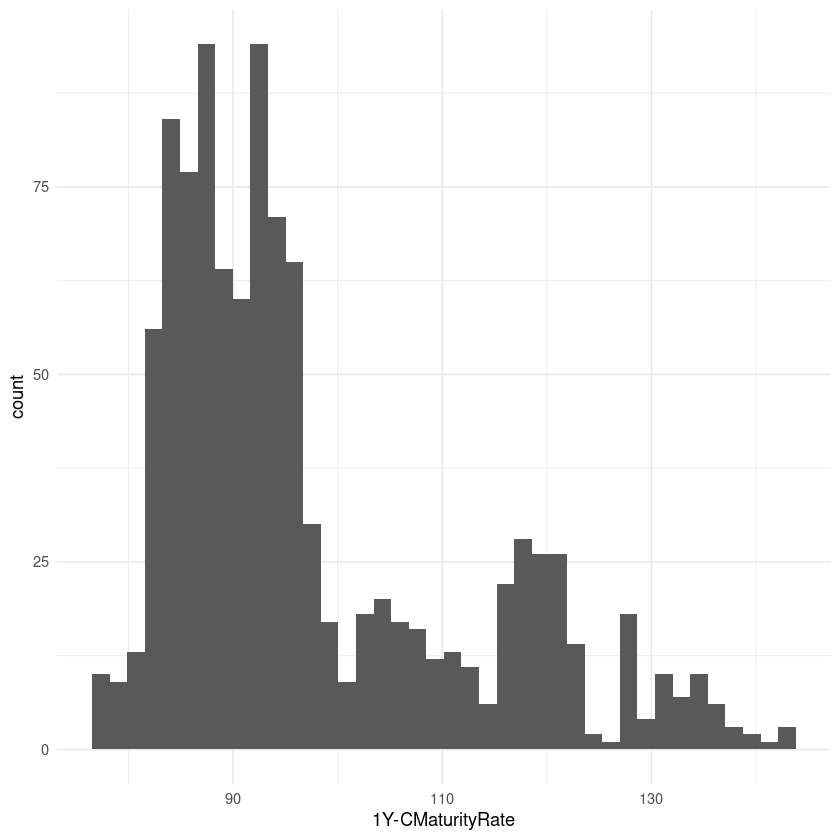

In [4]:
data %>% ggplot(aes(x=`1Y-CMaturityRate`)) + geom_histogram(bins=40) + theme_minimal()

In [5]:
data[duplicated(data),]

1Y-CMaturityRate,30Y-CMortgageRate,3M-Rate-AuctionAverage,3M-Rate-SecondaryMarket,3Y-CMaturityRate,5Y-CMaturityRate,bankCredit,currency,demandDeposits,federalFunds,moneyStock,checkableDeposits,loansLeases,savingsDeposits,tradeCurrencies,1MonthCDRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


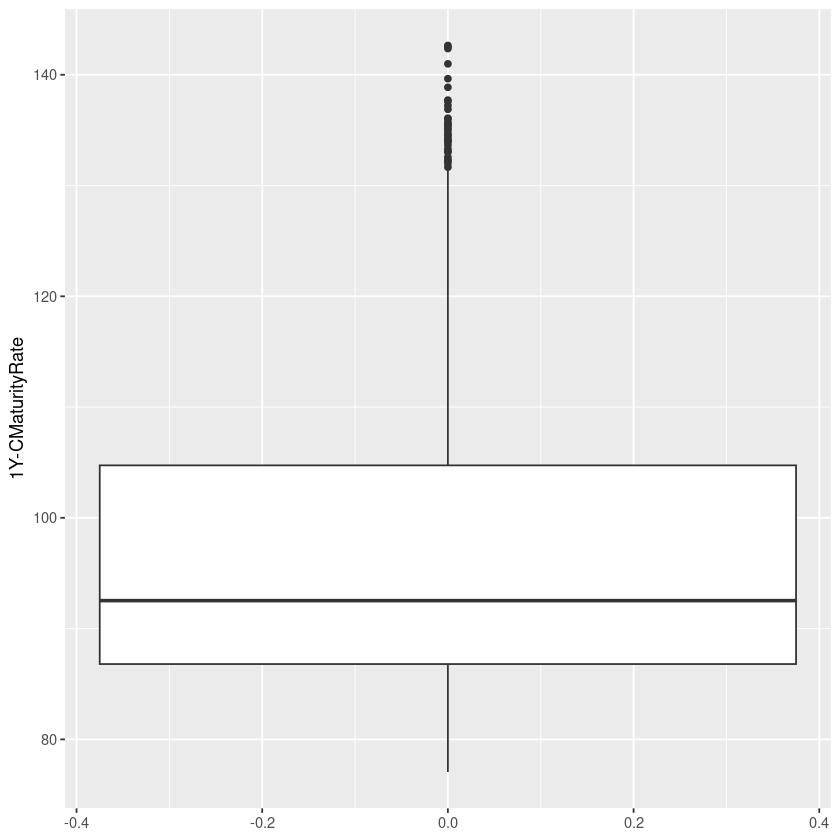

In [5]:
data %>% ggplot(aes(y=`1Y-CMaturityRate`)) + geom_boxplot(position="dodge")

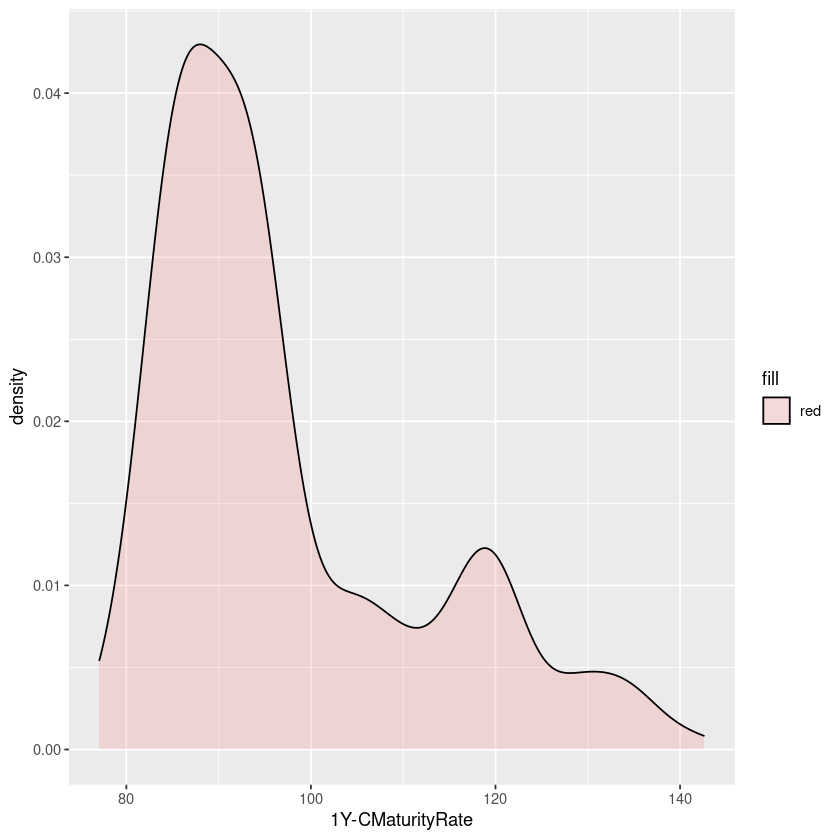

In [6]:
data %>% ggplot(aes(x=`1Y-CMaturityRate`,fill="red"))+ geom_density(stat="density",alpha=I(0.2)) 

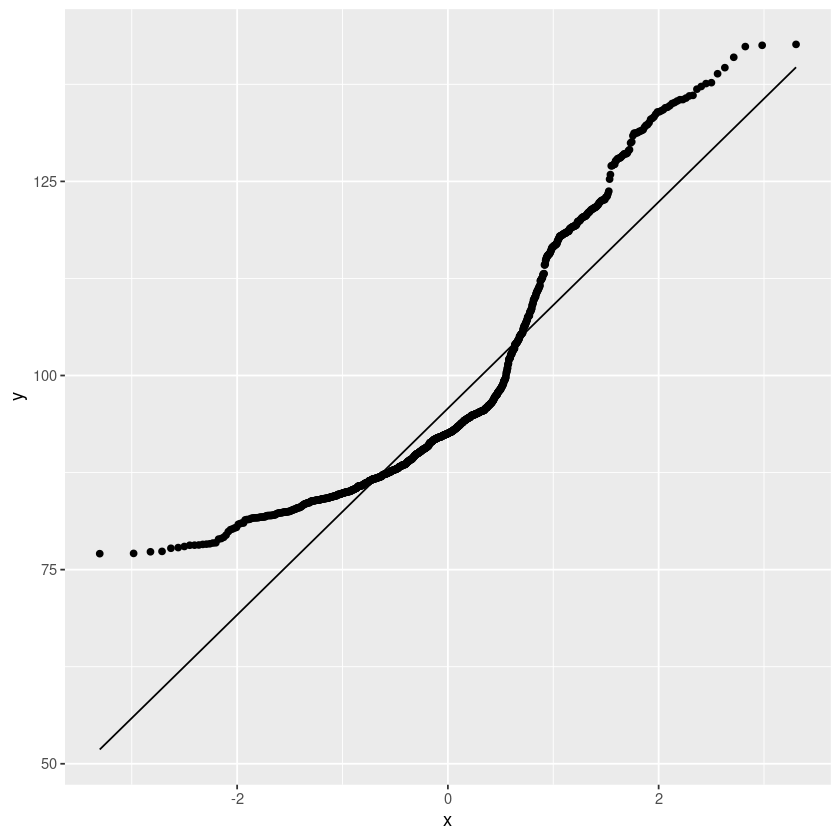

In [7]:
data %>% ggplot(aes(sample=`1Y-CMaturityRate`)) + stat_qq() + stat_qq_line()

In [8]:
 shapiro.test(data$`1Y-CMaturityRate`)


	Shapiro-Wilk normality test

data:  data$`1Y-CMaturityRate`
W = 0.87151, p-value < 2.2e-16


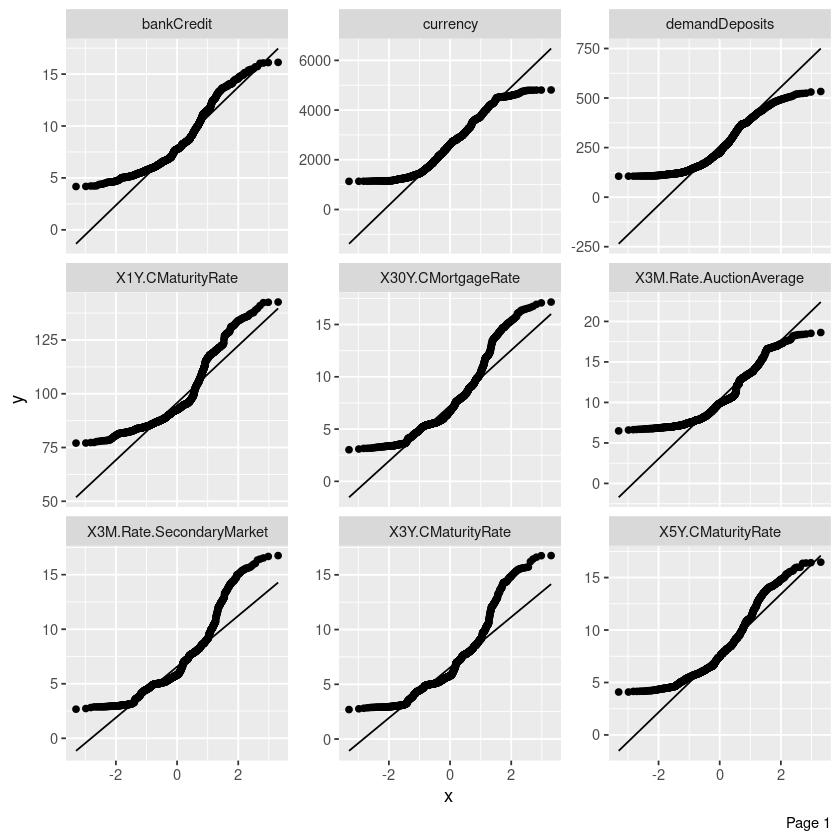

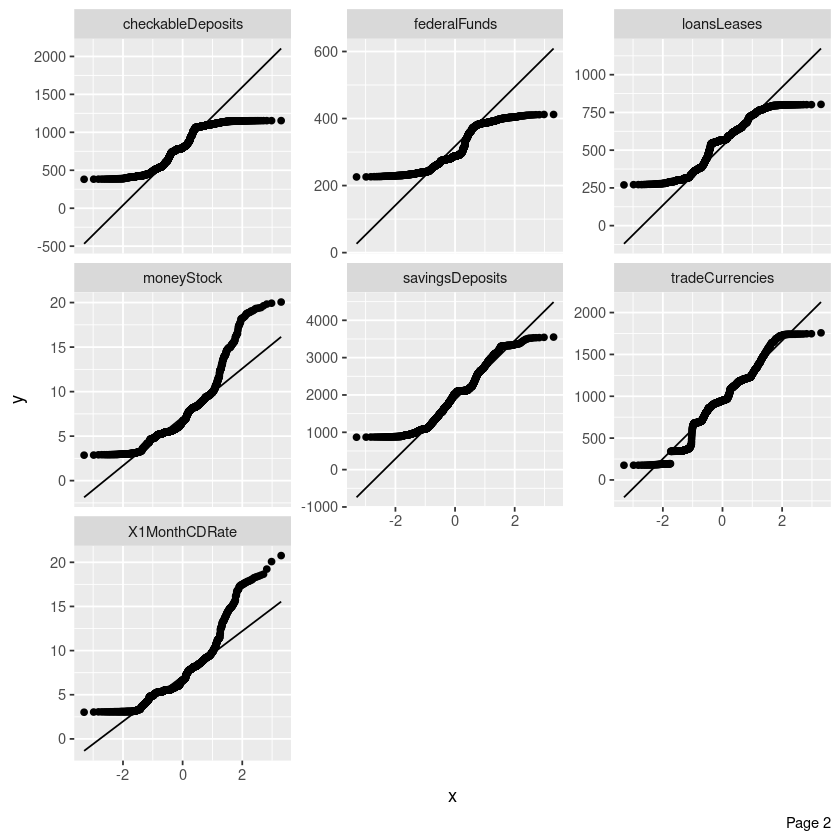

In [9]:
plot_qq(data)

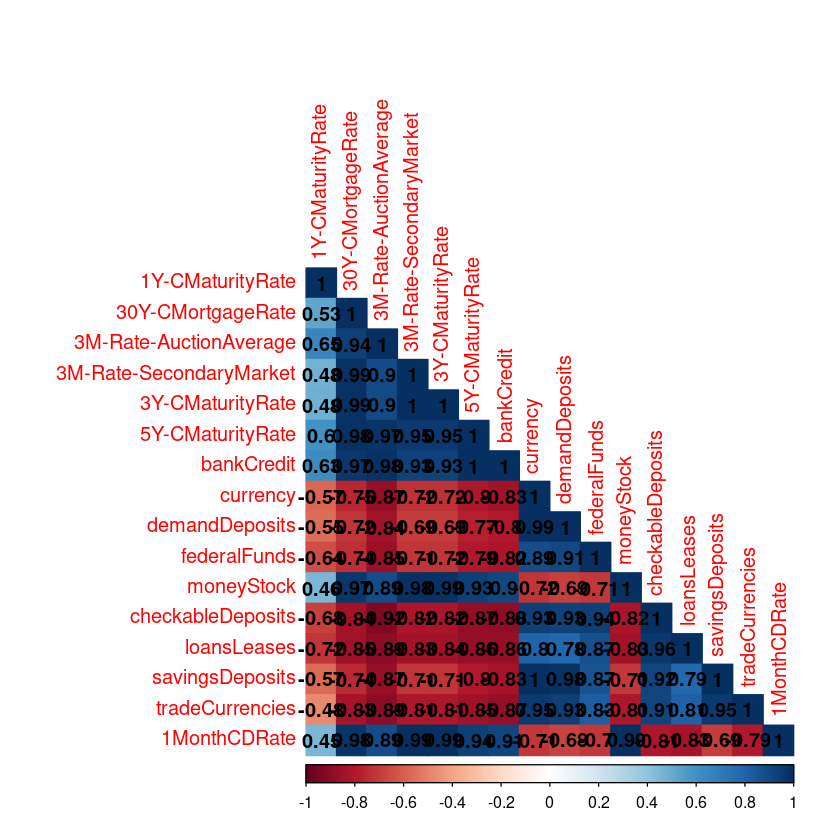

In [10]:
y= cor(data)
corrplot(y, method = "color", addCoef.col = "black", type = "lower")

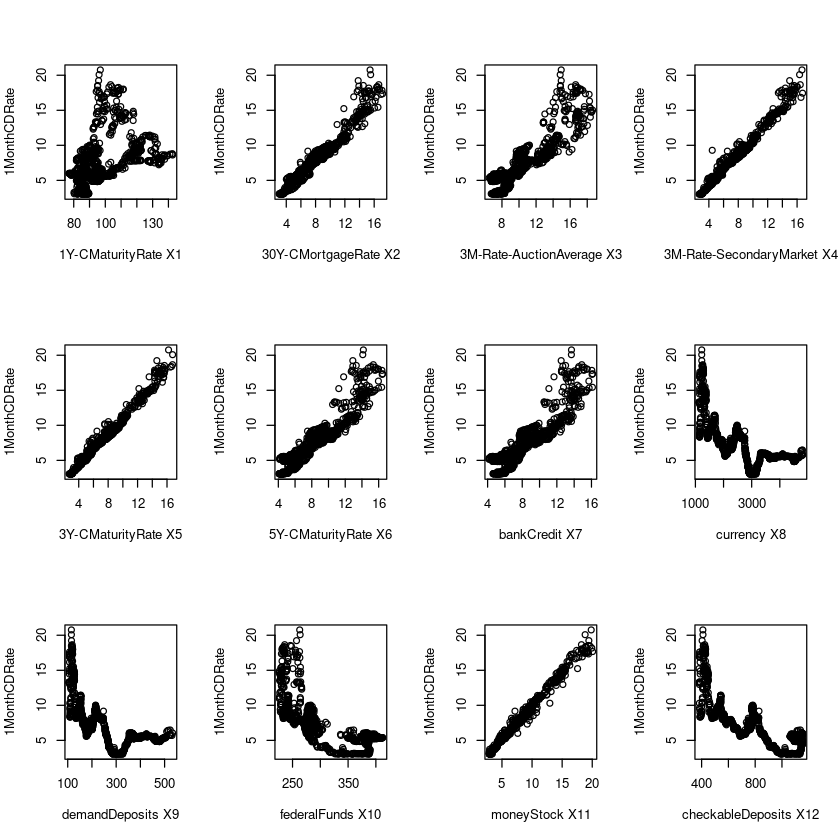

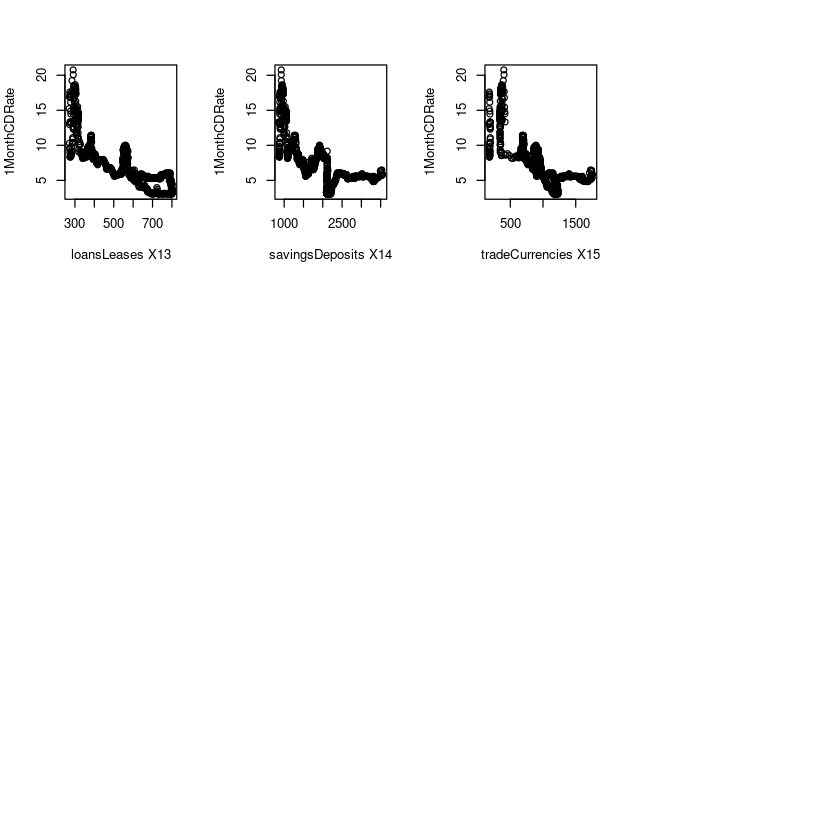

In [11]:
temp <- data
plotY <- function(x, y) {
    plot(temp[, y] ~ temp[, x],
        xlab = paste(names(temp)[x], " X", x, sep = ""),
        ylab = names(temp)[y]
    )
}
par(mfrow = c(3, 4)) # Si margin too large => (2,3)
x <- sapply(1:(dim(temp)[2] - 1), plotY, dim(temp)[2])
par(mfrow = c(1, 1))

In [12]:
datapca <- data %>% select(-`1MonthCDRate`)

mi.pca <- PCA(datapca, scale.unit=TRUE, ncp=4, graph=TRUE)

In [13]:
eig.vals<-get_eigenvalue(mi.pca)

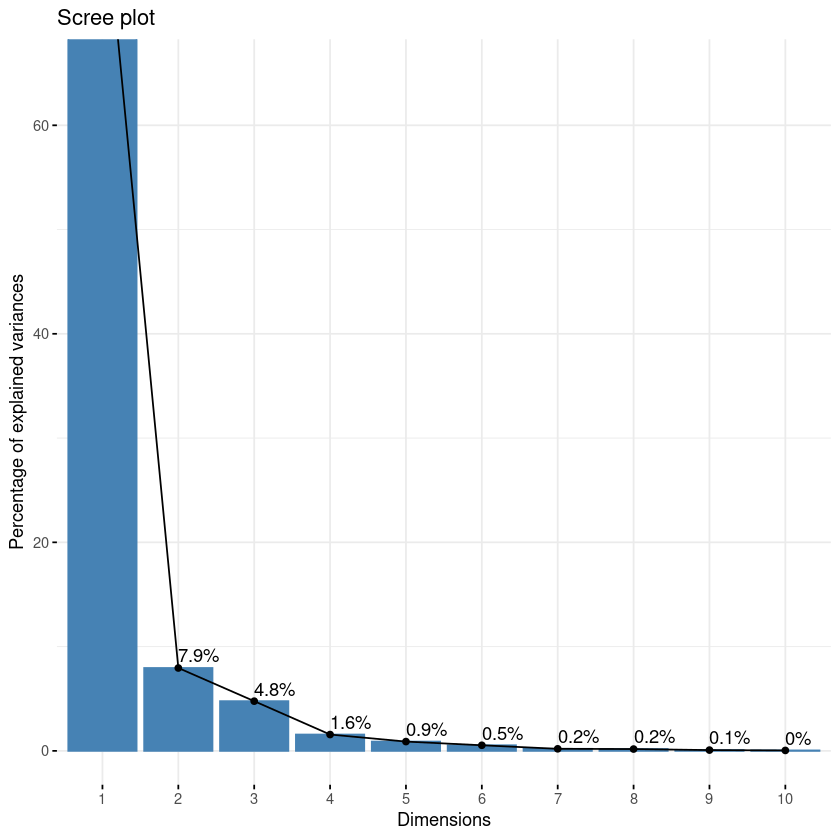

In [14]:
fviz_eig(mi.pca,
addlabels = TRUE,
ylim = c(0, 65))

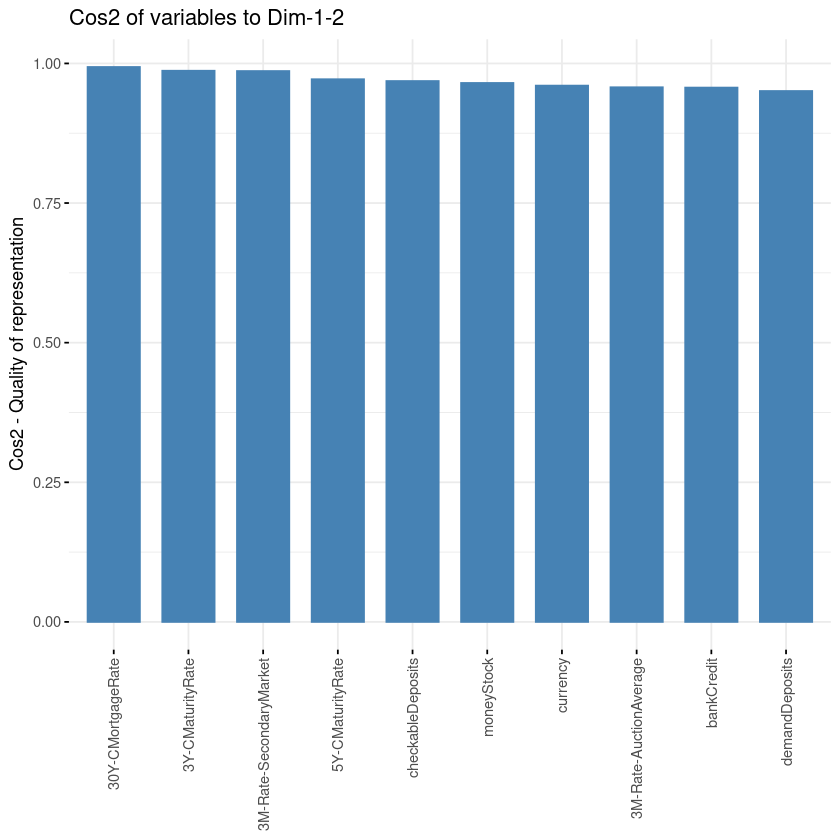

In [15]:
fviz_cos2(mi.pca,
choice = "var",
axes = 1:2,
xtickslab.rt = 90,
top=10)

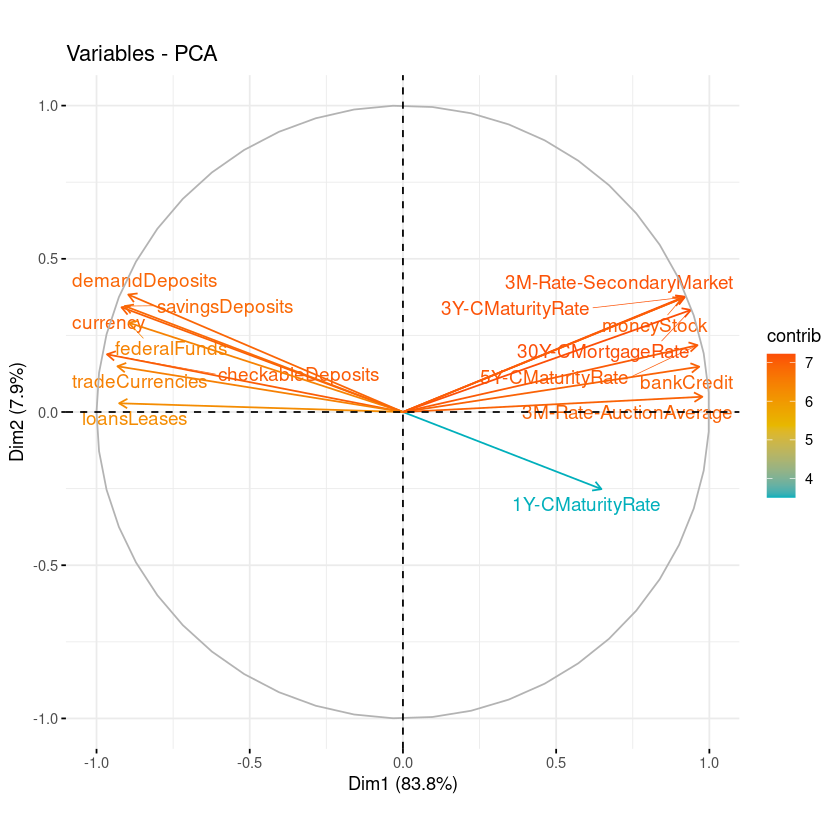

In [16]:
fviz_pca_var(mi.pca,
axes = c(1, 2),
col.var = "contrib",
gradient.cols = c("#00AFBB",
"#E7B800", "#FC4E07"),
repel = TRUE) # Avoid text overlapping

In [20]:
lasso_fit <- glmnet(x=as.matrix(datapca),y=data$`1MonthCDRate`,alpha=1.5)

coef(lasso_fit,s=0.5)

Warning message in glmnet(x = as.matrix(datapca), y = data$`1MonthCDRate`, alpha = 1.5):
“alpha >1; set to 1”


16 x 1 sparse Matrix of class "dgCMatrix"
                                s1
(Intercept)             1.18198851
1Y-CMaturityRate        .         
30Y-CMortgageRate       .         
3M-Rate-AuctionAverage  .         
3M-Rate-SecondaryMarket 0.02702088
3Y-CMaturityRate        0.34926773
5Y-CMaturityRate        .         
bankCredit              .         
currency                .         
demandDeposits          .         
federalFunds            .         
moneyStock              0.49931306
checkableDeposits       .         
loansLeases             .         
savingsDeposits         .         
tradeCurrencies         .         

Loading required package: Formula

Loading required package: plotrix

Loading required package: TeachingDemos



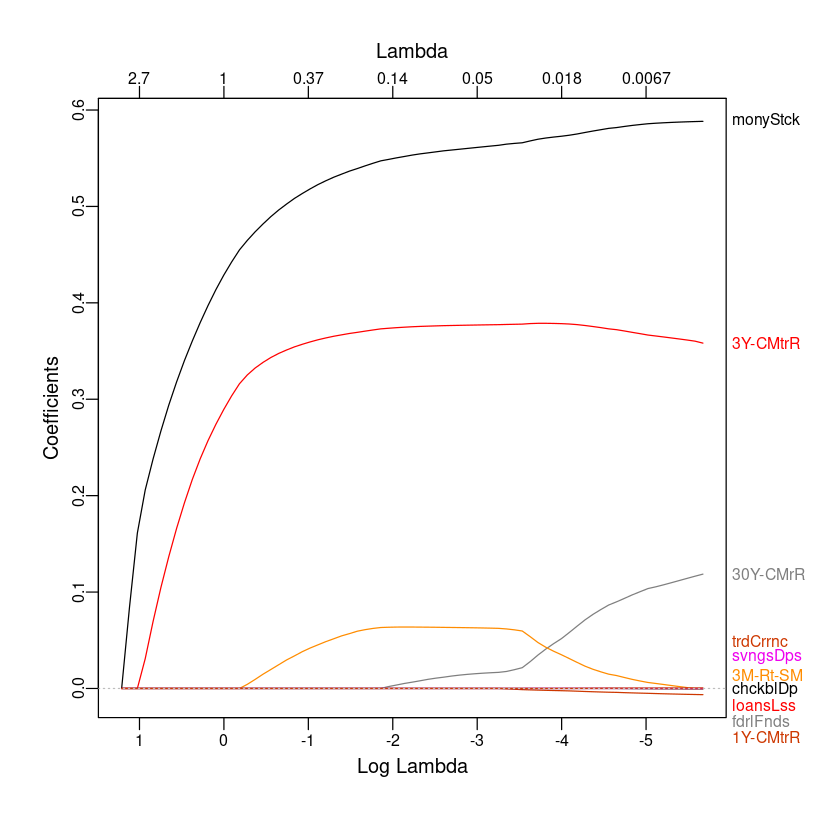

In [22]:
library(plotmo)
plot_glmnet(lasso_fit, label=TRUE)   